In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.integrate import cumtrapz

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

#Train Data
rawfeats = pd.read_csv('../data/dengue_features_train.csv')
rawlabels = pd.read_csv('../data/dengue_labels_train.csv')
rawfeats['total_cases'] = rawlabels['total_cases']
print(rawfeats.shape)

#Test Data
testfeats = pd.read_csv('data/dengue_features_test.csv')
print(testfeats.shape)

#Degrade outliers (see eda.ipynb for details)
sj = rawfeats[rawfeats.city=='sj'].copy()
sjtest = testfeats[testfeats.city=='sj'].copy()
iq = rawfeats[rawfeats.city=='iq'].copy()
iqtest = testfeats[testfeats.city=='iq'].copy()
to_trim = ['ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']
            
for v in to_trim:
    sj.loc[:,v] = [min(x, sjtest[v].max()) for x in sj[v]]
    sj.loc[:,v] = [max(x, sjtest[v].min()) for x in sj[v]]
    iq.loc[:,v] = [min(x, iqtest[v].max()) for x in iq[v]]
    iq.loc[:,v] = [max(x, iqtest[v].min()) for x in iq[v]]

rawfeats = pd.concat([sj,iq])
rawfeats.shape



(1456, 25)
(416, 24)
(936, 25)


In [33]:
def process_SJ(rawfeats, train=True):
    '''Returns a San Juan dataset ready for training or prediction'''
    #Fix Week Numbers 
    if train:
        rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==1993,
                                                    rawfeats.weekofyear+1, rawfeats.weekofyear)
        for year in [1994,1995,1999,2000,2005,2006]:
            rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==year,
                                                    rawfeats.weekofyear_fixed+1, rawfeats.weekofyear_fixed)
        rawfeats.loc[:,'weekofyear'] = np.where(rawfeats.weekofyear_fixed>52,
                                                    1, rawfeats.weekofyear_fixed)
        
    else:
        rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==2010,
                                                    rawfeats.weekofyear+1, rawfeats.weekofyear) 
        for year in [2011,2012]:
            rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==year,
                                                    rawfeats.weekofyear_fixed+1, rawfeats.weekofyear_fixed)
        rawfeats.loc[:,'weekofyear'] = np.where(rawfeats.weekofyear_fixed>52,
                                                    1, rawfeats.weekofyear_fixed)
    
    #Fill nas with interpolation
    feats = rawfeats.interpolate(method='linear')
    #Scale then average temperature readings 
    tempscols_to_average = feats.loc[:,['reanalysis_max_air_temp_k', 'station_avg_temp_c',
       'reanalysis_avg_temp_k', 'reanalysis_min_air_temp_k',
       'station_min_temp_c', 'reanalysis_dew_point_temp_k',
       'reanalysis_air_temp_k']]
    scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(tempscols_to_average), 
                            columns=tempscols_to_average.columns)
    feats.loc[:,'temps_mean'] = scaled_temps.mean(axis=1)
    #Boolean season variables
    cutoffs = [11, 30]
    feats['slowdown_season'] = np.where((feats.weekofyear<cutoffs[0]), 1, 0)

    feats['lull_season'] = np.where((feats.weekofyear>=cutoffs[0]) &
                               (feats.weekofyear<cutoffs[1]), 1, 0)
    feats['rampup_season'] = np.where((feats.weekofyear>=cutoffs[1]), 1, 0)
    #drop unneeded columns
    keep = ['total_cases','slowdown_season', 'lull_season', 'rampup_season',
            'station_max_temp_c','temps_mean', 'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2']
    for col in feats.columns:
        if col not in keep:
            feats = feats.drop(col, axis=1)
    #add shifted feats, 3 weeks
    to_shift = ['station_max_temp_c', 'temps_mean','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2'] 
    for i in to_shift:
        feats[i+'_1lag'] = feats[i].shift(-1)
        feats[i+'_2lag'] = feats[i].shift(-2)
        feats[i+'_3lag'] = feats[i].shift(-3)
    feats = feats.fillna(method='ffill')
    return feats

In [35]:
sj = process_SJ(sj)
sj.shape

C:\Users\anees\AppData\Local\Temp\ipykernel_21624\2624709110.py:23: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  feats = rawfeats.interpolate(method='linear')
C:\Users\anees\AppData\Local\Temp\ipykernel_21624\2624709110.py:53: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feats = feats.fillna(method='ffill')


(936, 24)

In [37]:
#Split
sj_X = sj.drop(['total_cases'], axis=1)
sj_y = sj.total_cases

X_train_sj, X_test_sj, y_train_sj, y_test_sj = train_test_split(
    sj_X, sj_y, test_size=0.3)
print(X_train_sj.shape)
print(X_test_sj.shape)

(655, 23)
(281, 23)


In [39]:
iq = rawfeats[rawfeats.city=='iq'].copy()
print(iq.shape)

def process_IQ(rawfeats, train=True):
    '''Returns a dataset ready for training or prediction'''
    #Fix Week Numbers
    if train:
        rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==2005,
                                                      rawfeats.weekofyear+1, rawfeats.weekofyear)
        rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==2006,
                                                      rawfeats.weekofyear_fixed+1, rawfeats.weekofyear_fixed)
        rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==2010,
                                                      rawfeats.weekofyear_fixed+1, rawfeats.weekofyear_fixed)
        rawfeats.loc[:,'weekofyear'] = np.where(rawfeats.weekofyear_fixed>52,
                                                      1, rawfeats.weekofyear_fixed)
    else:
        rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==2011,
                                                      rawfeats.weekofyear+1, rawfeats.weekofyear)
        rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==2012,
                                                      rawfeats.weekofyear_fixed+1, rawfeats.weekofyear_fixed)
        rawfeats.loc[:,'weekofyear'] = np.where(rawfeats.weekofyear_fixed>52,
                                                      1, rawfeats.weekofyear_fixed)

    
    #Fill nas with interpolation
    feats = rawfeats.interpolate(method='linear')
    #season features
    cutoffs = [12, 24, 36]
    feats['fall'] = np.where((feats.weekofyear<cutoffs[0]), 1, 0)

    feats['winter'] = np.where((feats.weekofyear>=cutoffs[0]) &
                               (feats.weekofyear<cutoffs[1]), 1, 0)
    feats['spring'] = np.where((feats.weekofyear>=cutoffs[1]) &
                               (feats.weekofyear<cutoffs[2]), 1, 0)
    feats['summer'] = np.where((feats.weekofyear>=cutoffs[2]), 1, 0)
    #drop unneeded columns
    keep = ['total_cases',
       'spring', 'summer', 'fall', 'winter', 'station_avg_temp_c',
       'reanalysis_min_air_temp_k','station_min_temp_c',
       'reanalysis_dew_point_temp_k','reanalysis_tdtr_k',
       'reanalysis_specific_humidity_g_per_kg',
       'precipitation_amt_mm']
    
    for col in feats.columns:
        if col not in keep:
            feats = feats.drop(col, axis=1)
    
    #add shifted feats, 3 weeks
    to_shift = ['station_avg_temp_c','reanalysis_min_air_temp_k', 'station_min_temp_c',
       'reanalysis_dew_point_temp_k', 'reanalysis_tdtr_k', 
       'reanalysis_specific_humidity_g_per_kg','precipitation_amt_mm']
    
    for i in to_shift:
        feats[i+'_1lag'] = feats[i].shift(-1)
        feats[i+'_2lag'] = feats[i].shift(-2)
        feats[i+'_3lag'] = feats[i].shift(-3)
    feats = feats.fillna(method='ffill')
    return feats
iq = process_IQ(iq)
iq.shape

(520, 25)


C:\Users\anees\AppData\Local\Temp\ipykernel_21624\2402743432.py:26: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  feats = rawfeats.interpolate(method='linear')
C:\Users\anees\AppData\Local\Temp\ipykernel_21624\2402743432.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feats = feats.fillna(method='ffill')


(520, 33)

In [41]:
iq_X = iq.drop(['total_cases'], axis=1)
iq_y = iq.total_cases

X_train_iq, X_test_iq, y_train_iq, y_test_iq = train_test_split(
    iq_X, iq_y, test_size=0.3)
print(X_train_iq.shape)
print(X_test_iq.shape)

(364, 32)
(156, 32)


In [45]:
#Define the parameters we want to cycle through
param_grid = {
    'max_depth': [5,10,20,35,50],
    'max_features': [2, 5, 'auto'],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [100, 200, 300],
}
# start = time.time()
# rfr = RandomForestRegressor(criterion='mae')
# gs = GridSearchCV(estimator=rfr, param_grid=param_grid,cv=3, n_jobs=-1)

# #Fit the grid search to data for SJ (Time Consuming)
# gs.fit(X_train_sj, y_train_sj)
# print(time.time() - start)
# #Let's see what came out best:
# sj_rf_params = gs.best_params_
# sj_rf_params
#Copy and pasted best param to prevent unnecessary rerunning of Grid Search
sj_rf_params = {'max_depth': 35,
 'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}
# start = time.time()
# rfr = RandomForestRegressor(criterion='mae')
# gs = GridSearchCV(estimator=rfr, param_grid=param_grid,cv=3, n_jobs=-1)

# #Fit the grid search to data for IQ (Time Consuming)
# gs.fit(X_train_iq, y_train_iq)
# print(time.time() - start)
# #Let's see what came out best:
# iq_rf_params = gs.best_params_
# iq_rf_params
iq_rf_params = {'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}
sj_rfr = RandomForestRegressor(**sj_rf_params, criterion='absolute_error')
iq_rfr = RandomForestRegressor(**iq_rf_params, criterion='absolute_error')
sj_rfr.fit(sj_X, sj_y)

iq_rfr.fit(iq_X, iq_y)
print('Training Complete!')

Training Complete!


In [47]:
testdata = pd.read_csv('../data/dengue_features_test.csv')
sj_test = testdata[testdata.city=='sj'].copy()
sj_test = process_SJ(sj_test, train=False)
#Should be 23 feat columns
sj_test.shape
(260, 23)
iq_test = testdata[testdata.city=='iq'].copy()
iq_test = process_IQ(iq_test)
#Should be 32 feat columns
iq_test.shape
(156, 32)
sj_pred = sj_rfr.predict(sj_test).astype(int)
iq_pred = iq_rfr.predict(iq_test).astype(int)
#Confirm no negative predictions
print(np.min(sj_pred))
print(np.min(iq_pred))

8
1


C:\Users\anees\AppData\Local\Temp\ipykernel_21624\2624709110.py:23: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  feats = rawfeats.interpolate(method='linear')
C:\Users\anees\AppData\Local\Temp\ipykernel_21624\2624709110.py:53: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feats = feats.fillna(method='ffill')
C:\Users\anees\AppData\Local\Temp\ipykernel_21624\2402743432.py:26: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  feats = rawfeats.interpolate(method='linear')
C:\Users\anees\AppData\Local\Temp\ipykernel_21624\2402743432.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or ob

C:\Users\anees\AppData\Local\Temp\ipykernel_21624\1435118009.py:7: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integral = cumtrapz(new_deriv, initial=0)


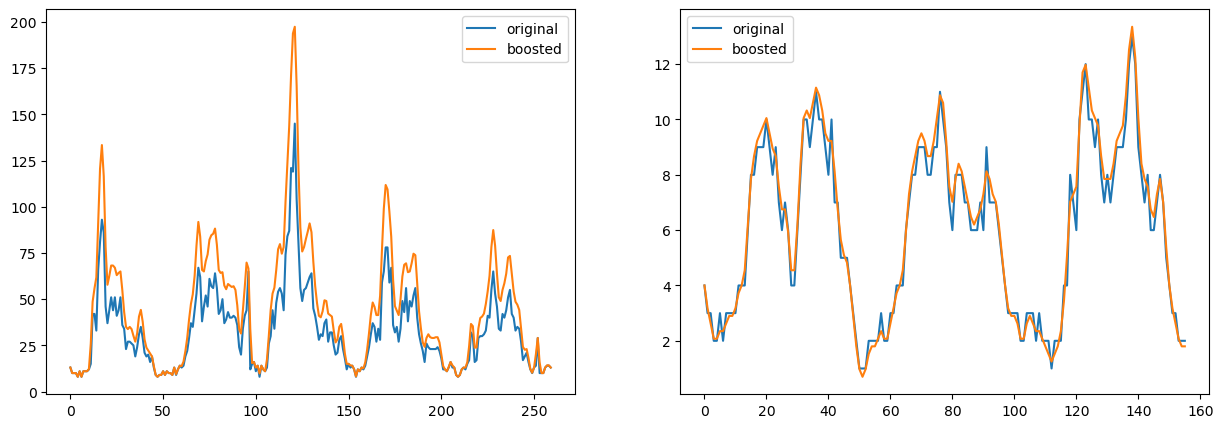

In [49]:
def peakBoost(array, scalar, mixed=None):
    #Take derivative of array
    deriv = np.gradient(array)
    #Scale derivative
    new_deriv = deriv * scalar
    #Integrate the new derivative starting from 0
    integral = cumtrapz(new_deriv, initial=0)
    length = range(len(array))
    #Add intercept to match initial range
    boosted = [x+array[0] for x in integral]
    
    #Option ways to put floors on the output
    if mixed == 'max':
        out = [max(boosted[i], array[i]) for i in length]
    elif mixed == 'pos':
        out = [max(boosted[i], 0) for i in length]
    else:
        out = boosted
    return out
sj_boost = peakBoost(sj_pred, 1.6, 'max')
iq_boost = peakBoost(iq_pred, 1.1, 'pos')
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(sj_pred, label='original')
plt.plot(sj_boost, label='boosted')
plt.legend()
plt.subplot(122)
plt.plot(iq_pred, label='original')
plt.plot(iq_boost, label='boosted')
plt.legend()
plt.show()

In [55]:
submission = pd.read_csv('../data/submission_format.csv',
                            index_col=[0, 1, 2])
submission.total_cases = np.concatenate([sj_pred, iq_pred])
submission.to_csv("submission.csv")